# Simplex aplicado à função Rosenbrock

Algoritmo simplex aplicado a um problema geofísico para estimar o raio e o topo de um prisma de base poligonal próximo de um cilindro.

# Importando pacotes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
import cPickle as pickle
from visual import histeq
from fatiando import utils
from fatiando.mesher import PolygonalPrism
from IPython.display import Image as img
from fatiando.gravmag import polyprism
from copy import deepcopy
from fatiando.gridder import regular

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


# Função geofísica

In [2]:
def geofisica(xp, yp, zp, p, M, dz, props, dobs, inc, dec):
    '''
    This function calculates the data for polygonal
    prisms of the Fatiando a Terra with the two given parameters.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    p: 1D array - parameter vector
    M: int - number of vertices
    L: int - number of prisms
    dz: float - thickness of each prism
    props: dictionary - physical property
    dobs: 1D array - observed data
    inc: float - inclination
    dec: declination

    output

    prism: list - list of objects of the class fatiando.mesher.PolygonalPrism
    d: 1D array - data vector
    res: 1D array - residual data
    phi: float - misfit function value
    '''
    
    r = np.zeros(M) + p[0] # radial distance for each vertice

    # Cartesian coordinates of the origin of each prism
    x0 = 0. 
    y0 = 0.

    l = [r, x0, y0, p[1], p[1] + dz, props]   # list of parameters of the prisms
    
    ang = 2*np.pi/M # angle between two vertices
    
    prism = []
    verts=[]
    for i in range(M):
        verts.append([r[i]*np.cos(i*ang) + l[1], r[i]*np.sin(i*ang) + l[2]])
    prism.append(PolygonalPrism(verts, l[3], l[4], l[5]))
    
    d = polyprism.tf(xp, yp, zp, prism, inc, dec)
    res = dobs - d
    phi = np.sum(res*res)
    
    return prism, d, res, phi

# Modelagem direta

In [3]:
M = 10 # number of vertices per prism
L = 1 # number of prisms
P = L*(M+2) # number of parameters

z0_true = 100.    # depth of the top the shallowest prism
dz = 500.    # thickness of each prism

inc = -60.  # inclination
dec = 50.   # declination
intensity = 0.035 # intensity

props={'magnetization': utils.ang2vec(intensity, inc, dec)} # physical property: magnetization

r_true = 500.

r = np.zeros(M) + r_true # radial distance for each vertice

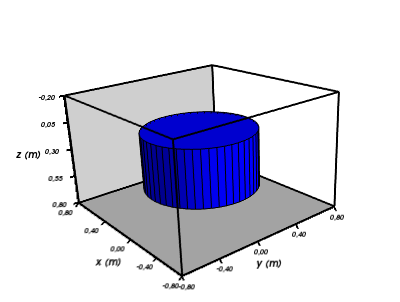

In [4]:
img(filename='bolacha.png')

# Pontos de observação

In [5]:
area = [-2000, 2000, -2000, 2000] #x minimum, x maximum, y minimum and y maximum
shape = (50,50) #number of data along the y and x directions
N = shape[0]*shape[1] #total number of data

#coordinates x and y of the data
xp, yp = regular(area, shape)

zp = np.zeros(N) - 100.

# Dados observados

In [6]:
p_true = np.array([r_true, z0_true])
prism_true, data, res_, phi_true = geofisica(xp, yp, zp, p_true, M, dz, props, np.zeros(xp.size), inc, dec)
amp_noise = 0.01*np.max(data)
data_noise = data + np.random.normal(loc=0., scale=amp_noise, size=shape[0]*shape[1]) # noise corrupted data

# Plot função desajuste

In [7]:
shape2 = (15,15)
r_plot = np.linspace(10., 1000., shape2[0])
z0_plot = np.linspace(-100., 500., shape2[1])
r_plot,z0_plot = np.meshgrid(r_plot, z0_plot)
r_plot = r_plot.ravel()
z0_plot = z0_plot.ravel()
phi_plot = np.zeros_like(r_plot)

for i, (r, z) in enumerate(zip(r_plot,z0_plot)):
    p = np.array([r, z])
    prism_pred, d_pred, res, phi_plot[i] = geofisica(xp, yp, zp, p, M, dz, props, data_noise, inc, dec)

r_plot = r_plot.reshape(shape2)
z0_plot = z0_plot.reshape(shape2)
phi_plot = phi_plot.reshape(shape2)

# equalizando as cores
phi_eq = histeq(phi_plot)
phi_eq = np.reshape(phi_eq,shape2)
phi_eq = phi_eq

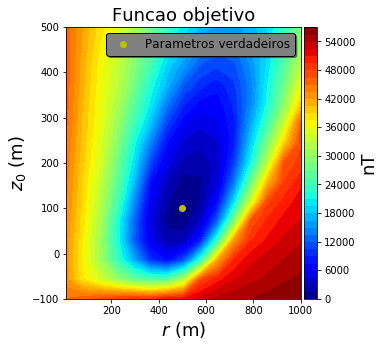

In [8]:
plt.figure(figsize=(5,5))
plt.plot(r_true, z0_true, 'oy', label='Parametros verdadeiros')
plt.title('Funcao objetivo', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 50, cmap='jet')
plt.xlabel('$r$ (m)', fontsize=18)
plt.ylabel('$z_0$ (m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1).set_label('nT', fontsize=18)
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, facecolor='gray', edgecolor='black')
plt.show()

# Chute inicial

In [9]:
# chute inicial
p0 = np.array([100.,300.,150.,400., 200., 350.]) 
p0 = np.reshape(p0, (3,2))

# valores da função para cada ponto
prism0 = []
d0 = np.zeros((3,shape[0]*shape[1]))
res0 = np.zeros((3,shape[0]*shape[1]))
phi0 = np.zeros(3)

for i, p in enumerate(p0):
    prism, d0[i], res0[i], phi0[i] = geofisica(xp, yp, zp, p, M, dz, props, data_noise, inc, dec)
    prism0.append(prism)

# identificando o valor mínimo
iL = np.argmin(phi0)

# armazenando o melhor chute
p1_list = [p0[iL][0]]
p2_list = [p0[iL][1]]
f_list = [phi0[iL]]

# parâmetros do código
alfa = 1.
gamma = 2.
beta = 0.5

# número de iteração máximo
itmax = 100

# parâmetros máximo e mínimo
p1max = 900.
p2max = 500.
p1min = 50.
p2min = 10.

# Algoritmo Simplex

In [10]:
for it in range(itmax):
    # verificando se os parâmetros estão na caixa
    i1max = np.argwhere(p0[:,0]>p1max)
    p0[i1max,1] = p1max
    i2max = np.argwhere(p0[:,1]>p2max)
    p0[i2max,1] = p2max
    i1min = np.argwhere(p0[:,0]<p1min)
    p0[i1min,1] = p1min
    i2min = np.argwhere(p0[:,1]<p2min)
    p0[i2min,1] = p2min
    
    # salvando snapshots
    #p0_movie = np.vstack((p0, p0[0,:]))
    #plot
    #plt.figure(figsize=(15,15))
    
    #plt.plot(p1_list, p2_list, '.w-', markersize=4)
    #plt.plot(p0_movie[:,0], p0_movie[:,1], 'o-w', markersize=5)
    #plt.plot(r_true, z0_true, 'oy')
    #plt.title('Simplex - Rosenbrock'+str(it), fontsize=18)
    #plt.contourf(r_plot, z0_plot, phi_eq, 50, cmap='jet')
    #plt.xlabel('$p_1$', fontsize=18)
    #plt.ylabel('$p_2$', fontsize=18)
    #plt.colorbar(pad=0.01, aspect=20, shrink=1)
    #plt.savefig('simplex_snap'+str(it)+'.png', pad_inches=0.0)
    
    # etapa 2: calcula f para cada par de parâmetros
    prism0 = []
    d0 = np.zeros((3,shape[0]*shape[1]))
    res0 = np.zeros((3,shape[0]*shape[1]))
    f0 = np.zeros(3)

    for i, p in enumerate(p0):
        prism, d0[i], res0[i], f0[i] = geofisica(xp, yp, zp, p, M, dz, props, data_noise, inc, dec)
        prism.append(prism)
    
    # etapa 3: defini-se os valores máximo e mínimo
    iH = np.argmax(f0)
    iL = np.argmin(f0)
    
    resL = res0[iL]
    
    fH = f0[iH]
    fL = f0[iL]
    fi = np.delete(f0, [iH, iL], 0)
    fi = np.float(fi)
    
    pH = p0[iH]
    pL = p0[iL]
    pi = np.delete(p0, [iH, iL], 0)
    pi = np.reshape(pi, (2,))
    #print pi
    
    p0d = np.delete(p0, iH, 0)
    f0d = np.delete(f0, iH, 0)
    # etapa 4: caçcula o centróide
    pC = 0.5*(p0d[0,:] + p0d[1,:])
    
    # etapa 5: reflexão
    pR = pC + alfa*(pC - pH)
    #print pR
    #print 'pH', pH, 'pL', pL, 'pi', pi, 'pC', pC, 'pR', pR
    
    # etapa 6: calcula fR
    prismR, dR, resR, fR = geofisica(xp, yp, zp, pR, M, dz, props, data_noise, inc, dec)
    #print 'fH', fH, 'fL', fL, 'fi', fi, 'fR', fR
    
    # etapa 6a
    if fR < fL:
        pE = pC + gamma*(pR - pC)
        prismE, dE, resE, fE = geofisica(xp, yp, zp, pE, M, dz, props, data_noise, inc, dec)
        # etapa 6a caso 1
        if fE <= fL:
            #pH = pE.copy()
            p = np.vstack((p0d, pE))
            f = np.hstack((f0d, fE))
            print '6a caso 1 pE:',pE, 'pi:', pi, 'pL:', pL, 'fE:%.2f, fL:%.2f e fi: %.2f' % (fE, fL, fi)
        # etapa 6a caso 2
        elif fE > fL:
            #pH = pR.copy()
            p = np.vstack((p0d, pR))
            f = np.hstack((f0d, fR))
            print '6a caso 2 pR:',pR, 'pi:', pi, 'pL:', pL, 'fE:%.2f, fR:%.2f e fi: %.2f' % (fE, fR, fi)
    # etapa 6b
    elif fL <= fR and fR < fi:
        #print fL
        #pH = pR.copy()
        p = np.vstack((p0d, pR))
        f = np.hstack((f0d, fR))
        print '6b pR:',pR, 'pi:', pi, 'pL:', pL, 'fL:%.2f, fR:%.2f e fi: %.2f' % (fL, fR, fi)
    # etapa 6c
    elif fR > f0d[0] and fR > f0d[1]:
        #print pcon, fcon
        # etapa 6c caso 1a
        if fR < fH:
            pcon = pC + beta*(pR - pC)
            prismcon, dcon, rescon, fcon = geofisica(xp, yp, zp, pcon, M, dz, props, data_noise, inc, dec)
            #print fcon, fR
            #pH = pcon.copy()
            if fcon < fR:
                p = np.vstack((p0d, pcon))
                f = np.hstack((f0d, fcon))
                print '6c caso 1a pcon:',pcon, 'pi:', pi, 'pL:', pL, 'fL:%.2f, fcon:%.2f e fi: %.2f' % (fL, fcon, fi)
            # etapa 6c caso 1b
            elif fcon >= fR:
                pH = 0.5*(pH + pL)
                pi = 0.5*(pi + pL)
                prismH, dH, resH, fH = geofisica(xp, yp, zp, pH, M, dz, props, data_noise, inc, dec)
                prismi, di, resi, fi = geofisica(xp, yp, zp, pi, M, dz, props, data_noise, inc, dec)
                #pH = pcond.copy()
                p = np.vstack((pL, pH))
                p = np.vstack((p, pi))
                f = np.hstack((fL, fH))
                f = np.hstack((f, fi))
                print '6c caso 1b pcond:',pH, 'e', pi, 'pL:', pL, 'fL:%.2f, fcondH:%.2f e fi: %.2f' % (fL, fH, fi)
        elif fR >= fH:
            pcon = pC + beta*(pH - pC)
            prismcon, dcon, rescon, fcon = geofisica(xp, yp, zp, pcon, M, dz, props, data_noise, inc, dec)
            # etapa 6c caso 2a
            if fcon < fH:
                #pH = pcon.copy()
                p = np.vstack((p0d, pcon))
                f = np.hstack((f0d, fcon))
                print '6c caso 2a pcon:',pcon, 'pi:', pi, 'pL:', pL, 'fL:%.2f, fcon:%.2f e fi: %.2f' % (fL, fcon, fi)
            # etapa 6c caso 2b
            elif fcon >= fH:
                #print pi
                pH = 0.5*(pH + pL)
                pi = 0.5*(pi + pL)
                prismH, dH, resH, fH = geofisica(xp, yp, zp, pH, M, dz, props, data_noise, inc, dec)
                prismi, di, resi, fi = geofisica(xp, yp, zp, pi, M, dz, props, data_noise, inc, dec)
                #pH = pcond.copy()
                p = np.vstack((pL, pH))
                p = np.vstack((p, pi))
                f = np.hstack((fL, fH))
                f = np.hstack((f, fi))
                print '6c caso 2b pcond:',pH, 'e', pi, 'pL:', pL, 'fL:%.2f, fcondL:%.2f e fi: %.2f' % (fL, fH, fi)

    #print p
    #print f
    #print abs((np.max(f) - np.min(f0))/np.min(f0))
    # printa os valores
    print 'iteração: %3d   p1: %.2f   p2: %.2f   f: %.2e' % (it, pL[0], pL[1], abs(np.sum(f - f0)/np.sum(f0)))
    p1_list.append(pL[0])
    p2_list.append(pL[1])
    f_list.append(fL)

    # critério de parada
    if abs(np.sum(f - f0)/f0.size) <= 1e-8:
        break
    else:
        # atualizando parâmetros
        p0 = p.copy()
        #print p0
        f0 = f.copy()
        #d0 = d
        #res0 = res
        #phi0 = phi
        #prim0 = pris

6a caso 1 pE: [ 325.  525.] pi: [ 150.  400.] pL: [ 200.  350.] fE:3715.36, fL:4149.49 e fi: 4624.69
iteração:   0   p1: 200.00   p2: 350.00   f: 8.09e-02
6a caso 1 pE: [ 487.5  475. ] pi: [ 200.  350.] pL: [ 325.  500.] fE:2380.30, fL:3625.96 e fi: 4149.49
iteração:   1   p1: 325.00   p2: 500.00   f: 1.81e-01
6b pR: [ 612.5  625. ] pi: [ 325.  500.] pL: [ 487.5  475. ] fL:2380.30, fR:2624.93 e fi: 3625.96
iteração:   2   p1: 487.50   p2: 475.00   f: 1.50e-01
6a caso 2 pR: [ 775.  475.] pi: [ 487.5  475. ] pL: [ 612.5  500. ] fE:3683.31, fR:1956.03 e fi: 2380.30
iteração:   3   p1: 612.50   p2: 500.00   f: 2.09e-01
6c caso 2a pcon: [ 590.625  481.25 ] pi: [ 612.5  500. ] pL: [ 775.  475.] fL:1956.03, fcon:1953.51 e fi: 1998.34
iteração:   4   p1: 775.00   p2: 475.00   f: 6.74e-02
6a caso 2 pR: [ 753.125  456.25 ] pi: [ 775.  475.] pL: [ 590.625  481.25 ] fE:2124.68, fR:1826.24 e fi: 1956.03
iteração:   5   p1: 590.62   p2: 481.25   f: 2.91e-02
6b pR: [ 568.75  462.5 ] pi: [ 590.625  48

# Plots de resultados

In [11]:
res_norm = (resL - np.mean(resL))/np.std(resL)
res_plot = resL.reshape(shape)
dpred = data.reshape(shape)
dobs = data_noise.reshape(shape)

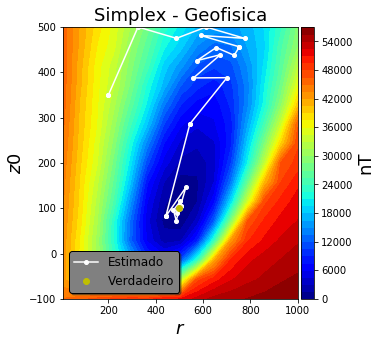

In [12]:
#plot
plt.figure(figsize=(5,5))
plt.plot(p1_list, p2_list, '.w-', markersize=8, label='Estimado')
plt.plot(r_true, z0_true, 'oy', label='Verdadeiro')
plt.title('Simplex - Geofisica', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 40, cmap='jet')
plt.xlabel('$r$', fontsize=18)
plt.ylabel('$z0$', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1).set_label('nT', fontsize=18)
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1, facecolor='gray', edgecolor='black')
plt.show()

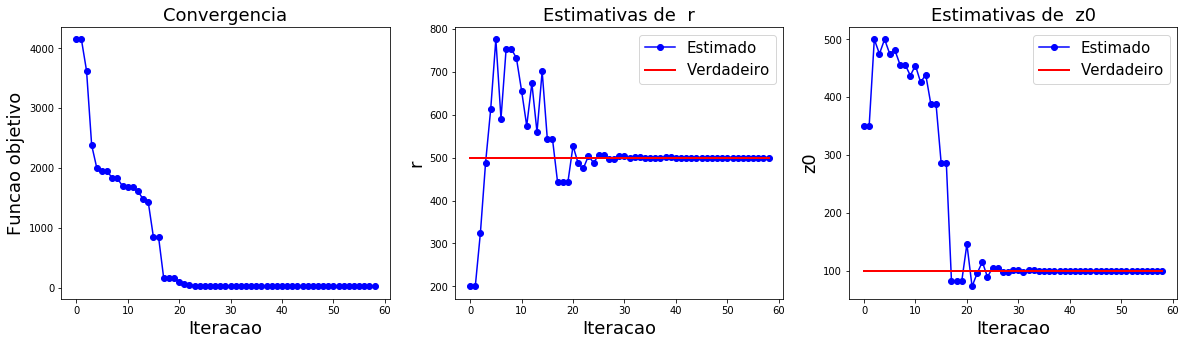

In [13]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Convergencia', fontsize = 18)
plt.ylabel('Funcao objetivo', fontsize = 18)
plt.xlabel('Iteracao', fontsize = 18)
plt.plot(f_list, 'bo-', label='Estimado')

plt.subplot(1, 3, 2)
plt.title('Estimativas de  r', fontsize = 18)
plt.xlabel('Iteracao', fontsize = 18)
plt.ylabel('r', fontsize = 18)
plt.plot(p1_list, 'bo-', label='Estimado')
plt.plot(np.zeros(len(p1_list)) + r_true, 'r-', linewidth=2, label='Verdadeiro')
plt.legend(loc=0, fontsize=15)

plt.subplot(1, 3, 3)
plt.title('Estimativas de  z0', fontsize = 18)
plt.xlabel('Iteracao', fontsize = 18)
plt.ylabel('z0', fontsize = 18)
plt.plot(p2_list, 'bo-', label='Estimado')
plt.plot(np.zeros(len(p1_list)) + z0_true, 'r-', linewidth=2, label='Verdadeiro')
plt.legend(loc=0, fontsize=15)
plt.show()

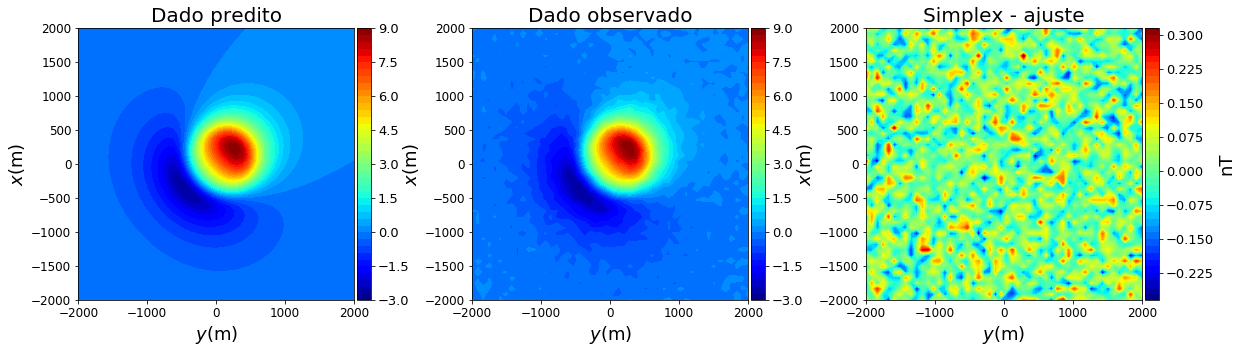

In [14]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Dado predito', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), dpred, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 2)
plt.title('Dado observado', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), dobs, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 3)
plt.title('Simplex - ajuste', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), res_plot, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.set_label('nT', fontsize=18)
clb.ax.tick_params(labelsize=13)
plt.show()

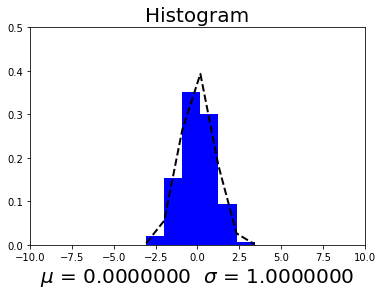

In [15]:
plt.plot(figsize=(30,25))
plt.title('Histogram', fontsize = 20)
plt.xlabel('$\mu$ = %.7f  $\sigma$ = %.7f' % (np.mean(res_norm), np.std(res_norm)), fontsize=20)
nbins = int((np.max(res_norm) - np.min(res_norm)))
n, bins, patches = plt.hist(res_norm,bins=nbins, normed=True, color='blue')
gauss = normpdf(bins, np.mean(res_norm), np.std(res_norm))
plt.plot(bins, gauss, 'k--', linewidth=2.)
plt.ylim(0.,0.5)
plt.xlim(-10., 10.)
plt.show()